<a href="https://colab.research.google.com/github/Bani-Talebi/Electricity-Price-Value-at-Risk-VaR-/blob/master/Triple_Exponential_Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


In [ ]:
up=files.upload()


Saving HOEP.csv to HOEP.csv


In [ ]:
df=pd.read_csv('HOEP.csv')
l=len(df)
df.index=pd.date_range(start='2010-01-01',periods=l,freq='H')
df.drop(columns=['Date','Hour'],inplace=True)
m=df.mean()
df=df-m

In [ ]:
tol = 1.5
data_prep = df.copy(deep=True)
    
# calculate quantiles and inter-quantile range of the data
q75 = data_prep['HOEP'].quantile(.75)
q25 = data_prep['HOEP'].quantile(.25)
IQR = q75 - q25

# values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaced by that value
data_prep['HOEP'] = data_prep['HOEP'].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
data_prep['HOEP'] = data_prep['HOEP'].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)
    


In [ ]:
Actual=df['2015':].values.reshape(1826,24)

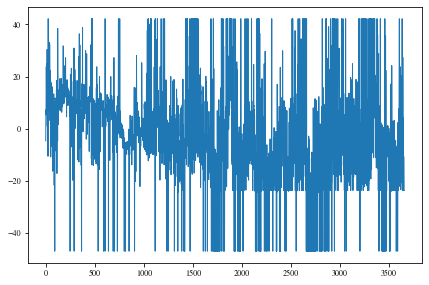

In [ ]:
#Y=df.values.reshape(3652,24)
Y=data_prep.values.reshape(3652,24)
y=Y[:,7]
Pred_TES=np.zeros([1826,24])
Pred_DES=np.zeros([1826,24])
plt.plot(y)

In [ ]:
for u in range(24):
  P_t=Y[:,u]
  z=np.array(P_t)
  l=len(z)

  s_t=z[:-1]
  s=s_t.mean()
  l=len(s_t)
  x=np.arange(1,l+1)
  p = np.polyfit(x, s_t, 2)

  beta2 = 2 * p[0]
  beta1 = p[1]
  beta0 = p[2]

  i = 0
  alpha = np.arange(0, 0.6, 0.01)
  SSE_TES = np.zeros(len(alpha))
  for a in alpha:
      w = 1 - a
      # Step1: Initialization
      S_1_n = beta0 - (w / a) * beta1 + (w * (1 - w) / (2 * a ** 2)) * beta2
      S_2_n = beta0 - (2 * w / a) * beta1 + (2 * w * (1 - 2 * w) / (2 * a ** 2)) * beta2
      S_3_n = beta0 - (3 * w / a) * beta1 + (3 * w * (1 - 3 * w) / (2 * a ** 2)) * beta2
      S_t = np.zeros(len(s_t))
      for n in range(len(s_t)):
          # Step2: Forecasting
          S_t[n] =(3+a*(1-5*w)/(2*w**2)+a**2/w**2)*S_1_n-(3+a*(1-4*w)/w**2+a**2/w**2)*S_2_n+(1+a*(1-3*w)/(2*w**2)+a**2/(2*w**2))*S_3_n
          # Step3: Updating
          S_1_n = (1 - w) * s_t[n] + w * S_1_n
          S_2_n = (1 - w) * S_1_n + w * S_2_n
          S_3_n = (1 - w) * S_2_n + w * S_3_n
      SSE_TES[i] = np.sum((s_t - S_t) ** 2)
      i = i + 1

  i = np.nanargmin(SSE_TES)
  a = alpha[i]
  w=1-a
  S_1_n = beta0 - (w / a) * beta1 + (w * (1 - w) / (2 * a ** 2)) * beta2
  S_2_n = beta0 - (2 * w / a) * beta1 + (2 * w * (1 - 2 * w) / (2 * a ** 2)) * beta2
  S_3_n = beta0 - (3 * w / a) * beta1 + (3 * w * (1 - 3 * w) / (2 * a ** 2)) * beta2
  S_t = np.zeros(len(s_t) + 1)
  S_t[0] = (3+a*(1-5*w)/(2*w**2)+a**2/w**2)*S_1_n-(3+a*(1-4*w)/w**2+a**2/w**2)*S_2_n+(1+a*(1-3*w)/(2*w**2)+a**2/(2*w**2))*S_3_n
  for n in range(len(s_t)):
      S_1_n = (1 - w) * s_t[n] + w * S_1_n
      S_2_n = (1 - w) * S_1_n + w * S_2_n
      S_3_n = (1 - w) * S_2_n + w * S_3_n
      S_t[n + 1] = (3+a*(1-5*w)/(2*w**2)+a**2/w**2)*S_1_n-(3+a*(1-4*w)/w**2+a**2/w**2)*S_2_n+(1+a*(1-3*w)/(2*w**2)+a**2/(2*w**2))*S_3_n
  Pred_TES[:,u]=S_t[-1826:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
MAE_TES=np.zeros(24)
for i in range(24):
  p=Pred_TES[:,i]
  y=Actual[:,i]
  MAE_TES[i]=mean_absolute_error(p,y)




In [ ]:
for u in range(24):
  P_t=Y[:,u]
  z=np.array(P_t)
  l=len(z)

  s_t=z[:-1]
  s=s_t.mean()
  l=len(s_t)
  x=np.arange(1,l+1)
  p = np.polyfit(x, s_t, 1)

  beta1 = p[0]
  beta0 = p[1]

  i = 0
  alpha = np.arange(0, 0.8, 0.01)
  SSE_DES = np.zeros(len(alpha))
  for a in alpha:
     
      # Step1: Initialization
      S_1_n=beta0-(1-a)/a*beta1
      S_2_n=beta0-2*(1-a)/a*beta1

      S_t = np.zeros(len(s_t))
      for n in range(len(s_t)):
          # Step2: Forecasting
          S_t[n] =(2+(a/(1-a)))*S_1_n-(1+(a/(1-a)))*S_2_n

          # Step3: Updating

          S_1_n=a*s_t[n]+(1-a)*S_1_n
          S_2_n=a*S_1_n+(1-a)*S_2_n
      SSE_DES[i] = np.sum((s_t - S_t) ** 2)
      i = i + 1

  i = np.nanargmin(SSE_DES)
  a = alpha[i]
  S_1_n=beta0-(1-a)/a*beta1
  S_2_n=beta0-2*(1-a)/a*beta1

  S_t = np.zeros(len(s_t) + 1)
  S_t[0] = (2+(a/(1-a)))*S_1_n-(1+(a/(1-a)))*S_2_n
  for n in range(len(s_t)):
      S_1_n=a*s_t[n]+(1-a)*S_1_n
      S_2_n=a*S_1_n+(1-a)*S_2_n
      S_t[n + 1] = (2+(a/(1-a)))*S_1_n-(1+(a/(1-a)))*S_2_n
  Pred_DES[:,u]=S_t[-1826:]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
MAE_DES=np.zeros(24)
for i in range(24):
  p=Pred_DES[:,i]
  y=Actual[:,i]
  MAE_DES[i]=mean_absolute_error(p,y)


In [ ]:
print(MAE_TES.mean())
print(MAE_DES.mean())

11.961803094429618
11.983819116668045


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

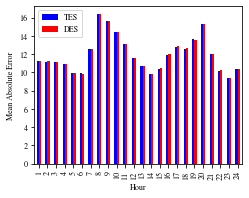

In [ ]:
plt.rcParams['font.family']='STIXGeneral'
plt.rcParams['font.size']=8
plt.rcParams['figure.autolayout']=True
plt.rcParams['axes.titlesize']=8
plt.rcParams['axes.labelsize']=8
plt.rcParams['lines.linewidth']=1
plt.rcParams['lines.markersize']=2
plt.rcParams['legend.fontsize']=8
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['mathtext.fontset']='custom'
plt.rcParams['legend.numpoints']=1

hour=np.arange(1,25)
#Vol_DF=pd.DataFrame({'Hour':hour,'Regularized TES':MAE_TES,'Regularized DES':MAE_DES})
Vol_DF=pd.DataFrame({'Hour':hour,'TES':MAE_TES,'DES':MAE_DES})

Vol_DF.index=Vol_DF.Hour
Vol_DF.drop(columns='Hour',inplace=True)
#Vol_DF.plot.bar(color={'Regularized TES':'blue','Regularized DES':'red'},figsize=(3.5,2.8),width=0.5)
Vol_DF.plot.bar(color={'TES':'blue','DES':'red'},figsize=(3.5,2.8),width=0.5)

plt.ylabel('Mean Absolute Error')
plt.savefig('VolForcst.pdf',dpi=300)
files.download('VolForcst.pdf')